In [11]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

tSI_data = genfromtxt('tSI_data.csv', delimiter=',') #in the form of [t, S, I]
tao_data = genfromtxt('tao_data.csv', delimiter=',') #in the form of [t, tao_star, T_star, us]


starting training...

self.alpha1[0] before training tensor(0.7136, grad_fn=<SelectBackward>)

self.alpha1 after the training:  tensor(0.7136, grad_fn=<SelectBackward>)

self.alpha1 after the training:  tensor(0.7136, grad_fn=<SelectBackward>)


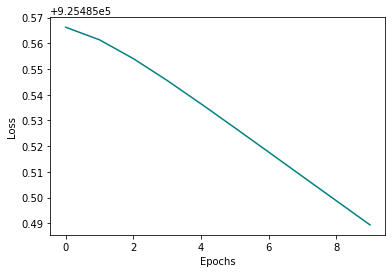

In [12]:
class DINN:
    def __init__(self, t, S_data, I_data, tao_data, T_star_data, u_data): #, t, S_data, I_data, tao_data, T_star_data, u
        self.t = torch.tensor(t, requires_grad = True).float()
        self.S = torch.tensor(S_data, requires_grad = True)
        self.I = torch.tensor(I_data, requires_grad = True)
        self.taos = torch.tensor(tao_data, requires_grad = True)
        self.T_stars = torch.tensor(T_star_data, requires_grad = True)
        self.u = torch.tensor(u_data, requires_grad = True).float()
        self.t_u = torch.stack((self.t, self.u), dim=1) #stack for the NN input 

        #learnable parameters
        self.alpha1=torch.nn.Parameter(torch.rand(len(t), requires_grad=True))
        self.alpha2=torch.nn.Parameter(torch.rand(len(t), requires_grad=True))
        self.mu=torch.nn.Parameter(torch.rand(len(t), requires_grad=True))
        self.beta=torch.nn.Parameter(torch.rand(len(t), requires_grad=True))

        #NN + params init
        self.nx = self.net_x()
        self.params = list(self.nx.parameters())
        self.params.extend(list([self.alpha1, self.alpha2, self.mu, self.beta]))
        
        #predictions
        #self.net_output = self.nx(self.t_u) #output size = (100,4)
        #self.S_pred = self.net_output[:,0]
        #self.I_pred = self.net_output[:,1]
        #self.tao_pred = self.net_output[:,2]
        #self.T_star_pred = self.net_output[:,3]
        self.S_pred = torch.rand(100 , requires_grad = True)
        self.I_pred = torch.rand(100 , requires_grad = True)
        self.tao_pred = torch.rand(100 , requires_grad = True)
        self.T_star_pred = torch.rand(100 , requires_grad = True)
        
    #networks
    class net_x(nn.Module): # input = [t, u]
        def __init__(self):
            super(DINN.net_x, self).__init__()
            self.fc1=nn.Linear(2, 20) #takes t, u
            self.fc2=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, tao, T*

        def forward(self, x):
            x=self.fc1(x)
            x=F.relu(self.fc2(x))
            x=self.out(x)
            return x    
    
    def net_f(self, t, u):
        #print('net_f')

        #need to fix this loop to be more efficient

        S_t_list = []
        I_t_list = [] 
        for input_tensor in self.t_u:
            output_tensor = self.nx(input_tensor)
            S_t_value = grad(output_tensor[0], input_tensor, retain_graph=True)[0][0] #derivative of S wrt t
            I_t_value = grad(output_tensor[1], input_tensor)[0][0] #derivative of I wrt t
            S_t_list.append(S_t_value)
            I_t_list.append(I_t_value)

        #convert to tensors
        S_t = torch.tensor(S_t_list, requires_grad = True)
        I_t = torch.tensor(I_t_list, requires_grad = True)
        
        f1 = S_t + self.beta * self.S_pred * self.I_pred + self.u * (t > self.tao_pred) * self.alpha1
        f2 = I_t - self.beta * self.S_pred * self.I_pred + self.mu * self.I_pred + self.u * (t > self.tao_pred) * self.alpha2
        return f1, f2
    
    #train    
    def train(self, n_epochs):
        print('\nstarting training...\n')
        losses = []
        print('self.alpha1[0] before training', self.alpha1[0])
        learning_rate = 0.01
        momentum = 0.5        
        optimizer = optim.SGD(self.params, lr = learning_rate, momentum = momentum)
        
        for epoch in range(n_epochs):
            #print('epoch', epoch)
            optimizer.zero_grad()
            #print('1')
            f1, f2 = self.net_f(self.t, self.u)
            #print('2')
            #print('f1, f2: ', f1, f2)
            #S_pred, I_pred, tao_pred, T_star_pred = self.nx(self.t_u)
            #print('S_pred, I_pred, tao_pred, T_star_pred: ', self.S_pred, self.I_pred, self.tao_pred, self.T_star_pred)    
            
            loss = (torch.mean(torch.square(self.S - self.S_pred))+torch.mean(torch.square(self.I - self.I_pred)) + #S,I 
                torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) \
                + #f1, f2
                torch.mean(torch.square(self.taos - self.tao_pred)) + torch.mean(torch.square(self.T_stars - self.T_star_pred))) #tao, T_star
            #print('loss', loss)
            #print('3')
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.nx.parameters(), 100) #gradient clipping
            optimizer.step()

            losses.append(loss)
            if epoch % 5 == 0:
                #print('\nepoch: ', epoch)
                #print('loss: ', losses[-1])
                print('\nself.alpha1 after the training: ', self.alpha1[0])
                #print('')
        plt.plot(losses, color = 'teal')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

dinn = DINN(tSI_data[0], tSI_data[1], tSI_data[2], tao_data[1], tao_data[2], tao_data[3]) #t, S_data, I_data, tao_data, T_star_data, u
dinn.train(10)